# Calculate Arctic Regional ice mass budget terms from Rufmod experiments

* **Description**: Reads in and creates regional integrated values from rufmod experiment
* **Input data**: Rufmod output in timeseries format
* **Output data**: Netcdf with processed ice state for all members
* **Creator**: Alice DuVivier
* **Date**: April 2022

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec

## Load mask file for getting area totals

In [2]:
# Grid
ds_grid = xr.open_dataset('/glade/p/cesm/omwg/grids/gx1v7_grid.nc')

# Get lat and lon
TLAT = ds_grid['TLAT']
TLONG = ds_grid['TLONG']

# rename some coordinates so things work properly!
TLAT = TLAT.rename({'nlat':'nj', 'nlon':'ni'})
TLONG = TLONG.rename({'nlat':'nj', 'nlon':'ni'})

In [3]:
# Load in masks
mask_in = ['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask', 'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask', 'Okhotsk_mask']

ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/REGION_MASK_gx1v7.nc')
ds_masks=ds_masks.rename({'lat':'nj','lon': 'ni'})
my_mask = ds_masks[mask_in].isel(time=0)

# now load in the different masks as a new coordinate
masks=xr.concat([my_mask.nh_mask,my_mask.Lab_mask,my_mask.GIN_mask,my_mask.Bar_mask,my_mask.ArcOc_mask,my_mask.Sib_mask,my_mask.Beau_mask,my_mask.Bering_mask,my_mask.Hudson_mask,my_mask.CAArch_mask,my_mask.Okhotsk_mask],dim='region')
masks['region']=mask_in

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Lab_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'GIN_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Bar_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'ArcOc_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decod

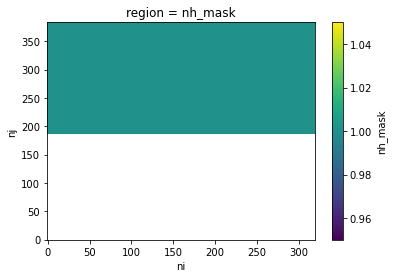

In [4]:
# verify it worked - choose one region to plot
masks.sel(region='nh_mask').plot()

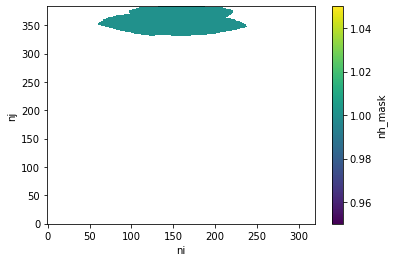

In [5]:
# make a combined mask
reg1 = 'ArcOc_mask'
reg2 = 'Bar_mask'
reg = reg1+'_and_'+reg2
mask_new_1= masks.sel(region=reg1).fillna(0) + masks.sel(region=reg2).fillna(0)
mask_new_1 = mask_new_1.where(mask_new_1 == 1)

mask_new_1.plot()

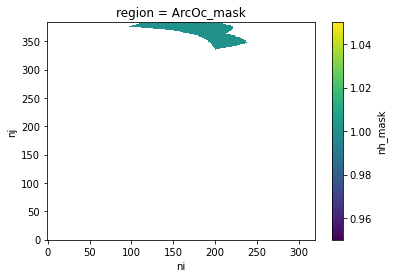

In [6]:
# Make a Canadian/Beaufort Mask
reg1 = 'ArcOc_mask'

reg = 'CanBeau_mask'
mask_new_2 = masks.sel(region=reg1).fillna(0)
mask_new_2 = mask_new_2.where(TLONG >= 193)
mask_new_2 = mask_new_2.where(mask_new_2 == 1)

mask_new_2.plot()

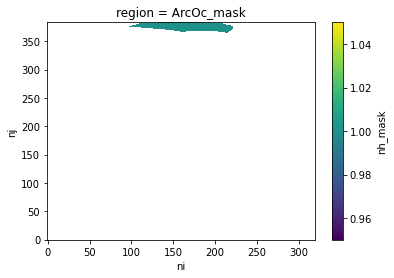

In [7]:
# Make a Canadian/Beaufort Mask
reg1 = 'ArcOc_mask'

reg = 'CanCoast_mask'
mask_new_3 = masks.sel(region=reg1).fillna(0)
mask_new_3 = mask_new_3.where(TLONG >= 250)
mask_new_3 = mask_new_3.where(mask_new_2 == 1)

mask_new_3.plot()

In [8]:
# Add three new masks
n=3

# Add this mask to the "masks" array
mask_in_new = ['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask', 'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask', 'Okhotsk_mask', 'ArcOc_mask_and_Bar_mask', 'CanBeau_mask', 'CanCoast_mask']

# new numpy array
masks_tmp = np.zeros([len(mask_in)+n,len(masks.nj),len(masks.ni)])
# fill it
masks_tmp[0:len(mask_in),:,:] = masks
masks_tmp[len(mask_in),:,:] = mask_new_1
masks_tmp[len(mask_in)+1,:,:] = mask_new_2
masks_tmp[len(mask_in)+2,:,:] = mask_new_3

# convert the numpy array to a xarray
masks_new = xr.DataArray(masks_tmp,dims=('region','nj','ni'))

# set coordinate arrays
masks_new['region'] = mask_in_new
masks_new['nj'] = masks['nj'].values
masks_new['ni'] = masks['ni'].values


In [9]:
# just rename so "new" array is the only array for masking
masks = masks_new

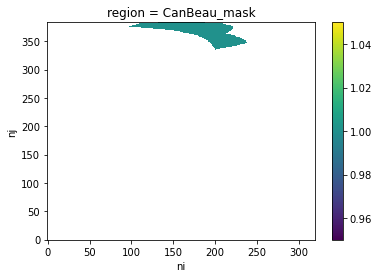

In [10]:
# test this
#masks.sel(region='ArcOc_mask_and_Bar_mask').plot()
#masks.sel(region='CanCoast_mask').plot()
masks.sel(region='CanBeau_mask').plot()

#masks.sel(region='ArcOc_mask').plot()

## Choose the variable to process

In [41]:
# list the variables to load
var_in = 'hi'

# aice, hi

## Load rufmod experiments

In [42]:
# Load "rufmod" data
#choose cases and data paths
case1 = 'b.e21.BSSP370.f09_g17.rufmod.001'
case2 = 'b.e21.BSSP370.f09_g17.rufmod.002'
case3 = 'b.e21.BSSP370.f09_g17.rufmod.003'
case4 = 'b.e21.BSSP370.f09_g17.rufmod.004'
case5 = 'b.e21.BSSP370.f09_g17.rufmod.005'

# set base directory where all data live
data_dir = '/glade/campaign/cesm/development/pcwg/projects/arctic_cyclones/rufmod_expts/'
# set individual data directories
data_dir1 = data_dir+case1+'/ice/proc/tseries/month_1/'
data_dir2 = data_dir+case2+'/ice/proc/tseries/month_1/'
data_dir3 = data_dir+case3+'/ice/proc/tseries/month_1/'
data_dir4 = data_dir+case4+'/ice/proc/tseries/month_1/'
data_dir5 = data_dir+case5+'/ice/proc/tseries/month_1/'

In [43]:
%%time
#reading in files
ds1 = []
ds2 = []
ds3 = []
ds4 = []
ds5 = []

print("loading "+var_in)   
my_files=sorted(glob.glob(data_dir1+case1+'.cice.h.'+var_in+'.*.nc'))
ds1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cice.h.'+var_in+'.*.nc'))
ds2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cice.h.'+var_in+'.*.nc'))
ds3=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cice.h.'+var_in+'.*.nc'))
ds4=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cice.h.'+var_in+'.*.nc'))
ds5=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

# verify it worked - plot first time only
#ds1["aice"].isel(time=0).plot()

loading hi
CPU times: user 658 ms, sys: 47 ms, total: 705 ms
Wall time: 3.89 s


In [44]:
futures = xr.concat([ds1,ds2,ds3,ds4,ds5],dim='member_id')

In [45]:
futures.member_id.values

# assign member_id as coordinate array
futures.assign_coords({"member_id": futures.member_id.values})

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 5, time: 1032, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id    (member_id) int64 0 1 2 3 4
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 600, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 600, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 600, 2), meta=np.ndarray>
    hi           (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BSSP370.f09_g17.rufmod.001
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20150201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-07-14 at 12:33
    io_flavor:         io_pio

In [46]:
ds_all = futures

In [47]:
ds_all

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 5, time: 1032, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: nj, ni, member_id, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 600, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 600, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 600, 2), meta=np.ndarray>
    hi           (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BSSP370.f09_g17.rufmod.001
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20150201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-07-14 at 12:33
    io_flavor:         io_pio

In [48]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
ds_all.time_bounds.load().mean(dim='d2').sel(member_id=0)

<xarray.DataArray 'time_bounds' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00

In [49]:
ds_all['time'] = ds_all.time_bounds.load().mean(dim='d2').sel(member_id=0)

In [50]:
ds_all.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [51]:
ds_all

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 5, time: 1032, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: nj, ni, member_id, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 600, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 600, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object 2015-01-01 00:00:00 ... 2101-01...
    hi           (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BSSP370.f09_g17.rufmod.001
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20150201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-07-14 at 12:33
    io_flavor:         io_pio

## Apply masks to the dataset

In [52]:
#mask just regions to calculate total ice area and ice volumes
ds_all_masked = ds_all[var_in]*masks

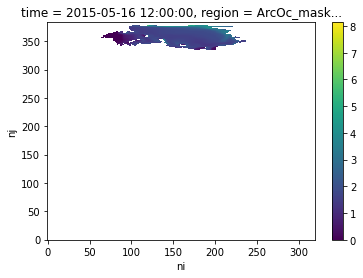

In [53]:
#just test that it worked properly
ds_all_masked.sel(member_id=0,region='ArcOc_mask_and_Bar_mask').isel(time=4).plot()

## Calculate regional totals

Total Ice area = sum over lat/lon of (aice*tarea). Units = m2

Ice volume = sum over lat/lon of (hi*tarea). Units = m3

Note that tarea is in cm^2

In [54]:
# get pop grid
grid = pop_tools.get_grid('POP_gx1v7')
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60, nreg: 13)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    ...           ...
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

In [55]:
# convert tarea to m^2
tarea = grid['TAREA']/(1e4)
tarea=tarea.rename({'nlat':'nj','nlon': 'ni'})

In [56]:
# multiply the values by tarea to get total area(m2) or volume(m3) of ice
masked_area = ds_all_masked*tarea

In [57]:
masked_area

<xarray.DataArray (member_id: 5, time: 1032, nj: 384, ni: 320, region: 14)>
dask.array<mul, shape=(5, 1032, 384, 320, 14), dtype=float64, chunksize=(1, 600, 384, 320, 14), chunktype=numpy.ndarray>
Coordinates:
  * nj       (nj) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * ni       (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
    TLON     (nj, ni) float32 320.6 321.7 322.8 323.9 325.1 ... nan nan nan nan
    TLAT     (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan nan
    ULON     (nj, ni) float32 321.1 322.2 323.4 324.5 325.6 ... nan nan nan nan
    ULAT     (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan nan
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * region   (region) <U23 'nh_mask' 'Lab_mask' ... 'CanCoast_mask'
Dimensions without coordinates: member_id

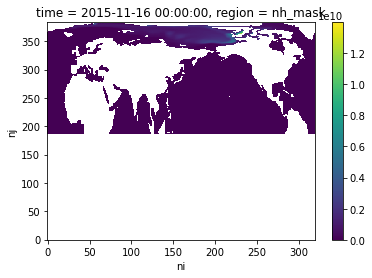

In [58]:
#just test that it worked properly
masked_area.sel(member_id=0,region='nh_mask').isel(time=10).plot()

In [59]:
# Get regional totals by summing over both spatial dimensions

# also convert to km2 or km3 depending on the input variable
if var_in == 'aice':
    factor = 1e6
    longname = 'regional total ice area'
    units = 'km^2'
else:
    factor = 1e9
    longname = 'regional total ice volume'
    units = 'km^3'

total = (masked_area.sum(dim='nj').sum(dim='ni'))/factor

In [60]:
#check the output here!
total.sel(region='nh_mask',member_id=0).values

array([1.30218644e+04, 1.60652860e+04, 1.86121761e+04, ...,
       1.51038078e+00, 3.22250324e+01, 7.37629724e+02])

### Actually load the data now

Before, all the calculations were "lazy" version

In [61]:
%%time
## slow step
total.load()

CPU times: user 55.2 s, sys: 1min 30s, total: 2min 26s
Wall time: 2min 33s


<xarray.DataArray (member_id: 5, time: 1032, region: 14)>
array([[[1.30218644e+04, 6.84348186e+02, 9.81559760e+02, ...,
         9.83801252e+03, 4.22310888e+03, 1.67015223e+03],
        [1.60652860e+04, 9.34238946e+02, 1.19013892e+03, ...,
         1.15966176e+04, 4.83801798e+03, 1.85419056e+03],
        [1.86121761e+04, 1.08105113e+03, 1.21338431e+03, ...,
         1.33507948e+04, 5.40997566e+03, 1.96786248e+03],
        ...,
        [1.51038078e+00, 1.39080146e-03, 0.00000000e+00, ...,
         1.50898997e+00, 2.16081306e-01, 6.74459319e-02],
        [3.22250324e+01, 7.28844729e+00, 4.29273274e-01, ...,
         1.82344475e+01, 1.61459759e+01, 1.57611709e+01],
        [7.37629724e+02, 5.95377448e+01, 8.31548042e+00, ...,
         6.22121357e+02, 2.60647198e+02, 1.85343415e+02]],

       [[1.30252100e+04, 6.81877935e+02, 9.47577169e+02, ...,
         9.89929942e+03, 4.21033404e+03, 1.66592526e+03],
        [1.64965315e+04, 9.17544649e+02, 1.14828195e+03, ...,
         1.21087190e+04, 4.88417631e+03, 1.84519049e+03],
        [1.90401966e+04, 1.06451738e+03, 1.38630922e+03, ...,
         1.36241501e+04, 5.35322184e+03, 1.99316385e+03],
...
        [2.35302126e-02, 0.00000000e+00, 6.30877905e-04, ...,
         2.28993347e-02, 2.17418672e-02, 2.17239549e-02],
        [1.19499936e+01, 6.91805246e-01, 5.21114686e-01, ...,
         8.79387121e+00, 8.79387121e+00, 8.79387121e+00],
        [2.40914245e+02, 1.77171200e+01, 1.88723472e+01, ...,
         1.81204120e+02, 1.19214167e+02, 1.14631024e+02]],

       [[1.30322652e+04, 6.84371488e+02, 9.45088879e+02, ...,
         9.87530214e+03, 4.24588026e+03, 1.69503917e+03],
        [1.63851040e+04, 9.40176640e+02, 1.11509842e+03, ...,
         1.18440249e+04, 5.12323580e+03, 1.97988250e+03],
        [1.87349604e+04, 1.08741440e+03, 1.26666742e+03, ...,
         1.32683851e+04, 5.75172530e+03, 2.08968722e+03],
        ...,
        [3.36181996e+00, 1.45108480e-01, 3.02410691e-02, ...,
         2.63575073e+00, 2.60442212e+00, 2.60165520e+00],
        [4.66309053e+01, 7.69296495e+00, 8.65280321e-01, ...,
         2.90133777e+01, 2.90128814e+01, 2.90128803e+01],
        [2.64353700e+02, 2.43953436e+01, 1.00947112e+01, ...,
         1.83485811e+02, 1.43775984e+02, 1.35699005e+02]]])
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * region   (region) <U23 'nh_mask' 'Lab_mask' ... 'CanCoast_mask'
Dimensions without coordinates: member_id

In [62]:
# assign member_id as coordinate array
total['member_id']=total.member_id.values

In [63]:
total.coords

Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * region     (region) <U23 'nh_mask' 'Lab_mask' ... 'CanCoast_mask'
  * member_id  (member_id) int64 0 1 2 3 4

In [64]:
total

<xarray.DataArray (member_id: 5, time: 1032, region: 14)>
array([[[1.30218644e+04, 6.84348186e+02, 9.81559760e+02, ...,
         9.83801252e+03, 4.22310888e+03, 1.67015223e+03],
        [1.60652860e+04, 9.34238946e+02, 1.19013892e+03, ...,
         1.15966176e+04, 4.83801798e+03, 1.85419056e+03],
        [1.86121761e+04, 1.08105113e+03, 1.21338431e+03, ...,
         1.33507948e+04, 5.40997566e+03, 1.96786248e+03],
        ...,
        [1.51038078e+00, 1.39080146e-03, 0.00000000e+00, ...,
         1.50898997e+00, 2.16081306e-01, 6.74459319e-02],
        [3.22250324e+01, 7.28844729e+00, 4.29273274e-01, ...,
         1.82344475e+01, 1.61459759e+01, 1.57611709e+01],
        [7.37629724e+02, 5.95377448e+01, 8.31548042e+00, ...,
         6.22121357e+02, 2.60647198e+02, 1.85343415e+02]],

       [[1.30252100e+04, 6.81877935e+02, 9.47577169e+02, ...,
         9.89929942e+03, 4.21033404e+03, 1.66592526e+03],
        [1.64965315e+04, 9.17544649e+02, 1.14828195e+03, ...,
         1.21087190e+04, 4.88417631e+03, 1.84519049e+03],
        [1.90401966e+04, 1.06451738e+03, 1.38630922e+03, ...,
         1.36241501e+04, 5.35322184e+03, 1.99316385e+03],
...
        [2.35302126e-02, 0.00000000e+00, 6.30877905e-04, ...,
         2.28993347e-02, 2.17418672e-02, 2.17239549e-02],
        [1.19499936e+01, 6.91805246e-01, 5.21114686e-01, ...,
         8.79387121e+00, 8.79387121e+00, 8.79387121e+00],
        [2.40914245e+02, 1.77171200e+01, 1.88723472e+01, ...,
         1.81204120e+02, 1.19214167e+02, 1.14631024e+02]],

       [[1.30322652e+04, 6.84371488e+02, 9.45088879e+02, ...,
         9.87530214e+03, 4.24588026e+03, 1.69503917e+03],
        [1.63851040e+04, 9.40176640e+02, 1.11509842e+03, ...,
         1.18440249e+04, 5.12323580e+03, 1.97988250e+03],
        [1.87349604e+04, 1.08741440e+03, 1.26666742e+03, ...,
         1.32683851e+04, 5.75172530e+03, 2.08968722e+03],
        ...,
        [3.36181996e+00, 1.45108480e-01, 3.02410691e-02, ...,
         2.63575073e+00, 2.60442212e+00, 2.60165520e+00],
        [4.66309053e+01, 7.69296495e+00, 8.65280321e-01, ...,
         2.90133777e+01, 2.90128814e+01, 2.90128803e+01],
        [2.64353700e+02, 2.43953436e+01, 1.00947112e+01, ...,
         1.83485811e+02, 1.43775984e+02, 1.35699005e+02]]])
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * region     (region) <U23 'nh_mask' 'Lab_mask' ... 'CanCoast_mask'
  * member_id  (member_id) int64 0 1 2 3 4

### Plot just to check

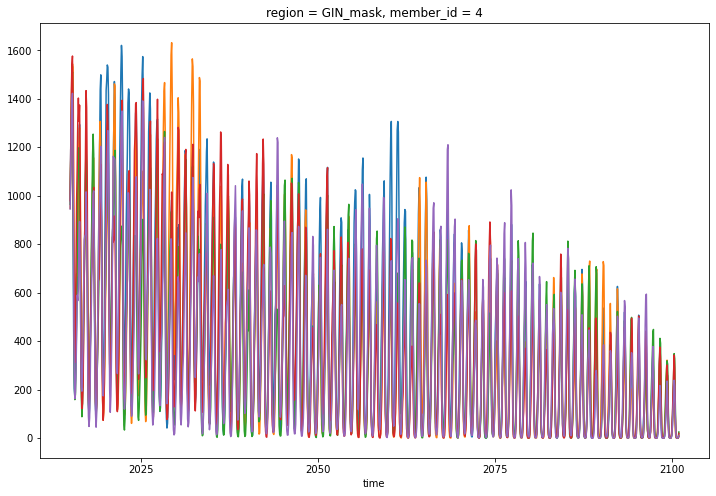

In [65]:
import nc_time_axis
# Setup the figure
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

# Loop through and plot each member_id all months in 251 years
for member_id in total.member_id.values:
    total.sel(region='GIN_mask',member_id=member_id).plot(ax=ax, label=member_id)

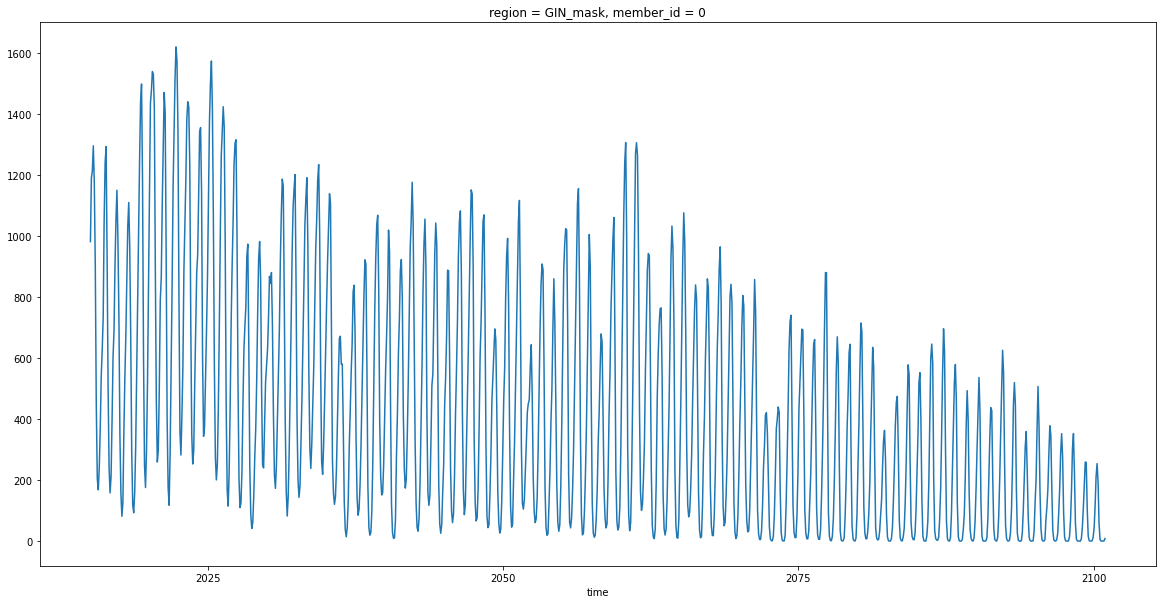

In [66]:
# Setup the figure
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

# Plot just one to check
total.sel(region='GIN_mask',member_id=0).plot(ax=ax, label='ens')

### Save the timeseries

In [67]:
fout = 'rufmod_all_transient_regional_total_'+var_in

In [68]:
ds_to_save = xr.Dataset({'regional_totals': (['member_id','time','region'], total.data)},
                        coords={'time':(['time'],total.time.values),
                                'member_id':(['member_id'],total.member_id.values),
                                'region':(['region'],total.region.values)},
                        attrs={'Author': 'Alice DuVivier', 'units':units, 'longname':longname})

In [69]:
# double check dataset we plan to save
ds_to_save

<xarray.Dataset>
Dimensions:          (member_id: 5, time: 1032, region: 14)
Coordinates:
  * time             (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id        (member_id) int64 0 1 2 3 4
  * region           (region) <U23 'nh_mask' 'Lab_mask' ... 'CanCoast_mask'
Data variables:
    regional_totals  (member_id, time, region) float64 1.302e+04 684.3 ... 135.7
Attributes:
    Author:    Alice DuVivier
    units:     km^3
    longname:  regional total ice volume

In [70]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file